In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
# Constants
SEQUENCE_LEN = 21 * 4              # 21 days of 6-hours data
OUTPUT_LEN = 5 * 4                 # 5 days of 6-hours data
INPUT_FEATURES = 23                # Number of input features (e.g., temperature, humidity, etc.)
OUTPUT_FEATURES = 5 * OUTPUT_LEN   # Predicting flatten 4 features for each timestamp (wind direction is described as two cols)

In [17]:
def wind_direction_sin_cos(data: pd.DataFrame):
    """ To avoid problem of huge MSE error degrees are replaced by sin and cos functions """
    data['Kierunek wiatru [sin]'] = np.sin(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
    data['Kierunek wiatru [cos]'] = np.cos(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
    data.drop('Kierunek wiatru  [°]', axis=1, inplace=True)
    return data

def create_sequences(data: pd.DataFrame):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :5].flatten()) # Taking the first 4 features for the next 24 hours
    return np.array(X), np.array(y)

def invert_scale_for_X(X: np.ndarray, scaler):
    copy_X = X.copy()
    for i in range(X.shape[-1]):
        print()
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_X[:, :, i] = X[:, :, i] * std + mean
    return copy_X

def invert_scale_for_y(y: np.ndarray, scaler):
    copy_y = y.copy()
    for i in range(5):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_y[:, i::5] = y[:, i::5] * std + mean
    return copy_y

def back_to_degrees_for_X(X: np.ndarray):
    sin_part, cos_part = X[:, :, 2], X[:, :, 3]  # get all 
    X[:, :, 2] = np.arctan2(sin_part, cos_part) * 180 / np.pi
    replaced_X = np.delete(X, 3, axis=2)
    return replaced_X

def back_to_degrees_for_y(y: np.ndarray):
    sin_part, cos_part = y[:, 2::5], y[:, 3::5]  # get all 
    y[:, 2::5] = np.arctan2(sin_part, cos_part) * 180 / np.pi
    replaced_y = np.delete(y, list(range(3, 99, 5)), axis=1)
    return replaced_y

def plot_one_prediction(idx: int, X_true, y_true, y_pred, figsize: Tuple[int] = (15, 10)):
    x = range(-SEQUENCE_LEN, OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperatura [°C]', 'Ciśnienie atmos. [hPa]', 'Kierunek wiatru [°]', 'Prędkość wiatru [m/s]']

    fig, axs = plt.subplots(4, figsize=figsize)
    fig.suptitle('Porównanie wyników modelu z faktycznym stanem pogody')
    for i in range(4):
        axs[i].plot(x1, X_true[idx + 1, :, i], label='Dane wejściowe', color='green')
        axs[i].plot(x2, y_true[:, i::4][idx], label='Wartość prawdziwa', color='blue')
        axs[i].plot(x2, y_pred[:, i::4][idx], label='Predykcja', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[3].set_xlabel('Czas [godz.]')
    plt.show()
    
def MSE(y_true: np.ndarray, y_pred: np.ndarray):
    T_mse = np.mean((y_true[:, 0::4] - y_pred[:, 0::4])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::4] - y_pred[:, 1::4])**2, axis=0).reshape(1, -1)
    WD_mse = np.mean((y_true[:, 2::4] - y_pred[:, 2::4])**2, axis=0).reshape(1, -1)
    WV_mse = np.mean((y_true[:, 3::4] - y_pred[:, 3::4])**2, axis=0).reshape(1, -1)
    MSE_by_hour = np.append(np.append(np.append(T_mse, P_mse, axis=0), WD_mse, axis=0), WV_mse, axis=0)
    
    return MSE_by_hour, np.mean(MSE_by_hour, axis=1), np.mean(MSE_by_hour)

In [5]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data_6h = data[data.index.hour.isin([0, 6, 12, 18])]
data_6h = wind_direction_sin_cos(data_6h)
data_6h

C:\Users\Tomek\AppData\Local\Temp\ipykernel_3600\1968659183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Kierunek wiatru [sin]'] = np.sin(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
C:\Users\Tomek\AppData\Local\Temp\ipykernel_3600\1968659183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Kierunek wiatru [cos]'] = np.cos(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
C:\Users\Tomek\AppData\Local\T

,Temperatura powietrza [°C]/1,Ciśnienie na poziomie stacji [hPa],Ciśnienie na poziomie morza [hPa],Ciśnienie pary wodnej [hPa],Widzialność operatora [m],Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],Chmury CL [kod],Chmury CM [kod],Chmury CH [kod],...,Wilgotność względna [%],Niedosyt wilgotności [hPa],Wystąpienie rosy [0/1],Wartość tendencji [wartość],Opad godzinowy [mm],Rodzaj opadu za 6 godzin [kod],Wysokość pokrywy śnieżnej [cm],Gatunek śniegu [kod],Kierunek wiatru [sin],Kierunek wiatru [cos]
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-6.8,995.8,1027.1,3.5,3500,0,0,0,0,0,...,95,0.2,0,-1.5,0.0,0.0,0.0,0,-0.052336,0.998630
2017-01-01 06:00:00,-7.1,992.9,1024.2,3.1,4000,0,0,0,0,0,...,87,0.5,0,-1.2,0.0,0.0,0.0,0,0.000000,1.000000
2017-01-01 12:00:00,4.5,989.9,1019.7,3.4,15000,0,0,0,0,0,...,40,5.1,0,-2.5,0.0,0.0,0.0,0,-0.707107,-0.707107
2017-01-01 18:00:00,-4.3,988.3,1019.1,3.6,4000,0,0,0,0,0,...,82,0.8,0,-0.5,0.0,0.0,0.0,0,-0.669131,-0.743145
2017-01-02 00:00:00,-6.8,986.1,1017.1,3.2,5000,0,0,0,0,0,...,88,0.4,0,-1.5,0.0,0.0,0.0,0,-0.974370,0.224951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 18:00:00,0.5,990.9,1021.2,5.8,5000,0,0,0,0,0,...,91,0.6,0,0.1,0.0,0.0,0.0,0,0.754710,0.656059
2022-12-31 00:00:00,-0.7,989.3,1019.7,5.6,2000,3,0,0,0,0,...,96,0.2,0,-1.0,0.0,0.0,0.0,0,0.292372,0.956305
2022-12-31 06:00:00,-0.3,989.4,1019.8,5.7,3500,5,1,0,0,0,...,95,0.3,0,0.3,0.0,0.0,0.0,0,0.000000,1.000000


In [6]:
cols = data_6h.columns
new_order = [0, 1, 21, 22, 11] + list(range(2, 11)) + list(range(12, 21))
cols = [cols[i] for i in new_order]
data_6h = data_6h[cols]
data_6h

,Temperatura powietrza [°C]/1,Ciśnienie na poziomie stacji [hPa],Ciśnienie na poziomie morza [hPa],Ciśnienie pary wodnej [hPa],Widzialność operatora [m],Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],Chmury CL [kod],Chmury CM [kod],Chmury CH [kod],...,Prędkość wiatru [m/s],Temperatura punktu rosy [°C],Wilgotność względna [%],Niedosyt wilgotności [hPa],Wystąpienie rosy [0/1],Wartość tendencji [wartość],Opad godzinowy [mm],Rodzaj opadu za 6 godzin [kod],Wysokość pokrywy śnieżnej [cm],Gatunek śniegu [kod]
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-6.8,995.8,1027.1,3.5,3500,0,0,0,0,0,...,1,-7.5,95,0.2,0,-1.5,0.0,0.0,0.0,0
2017-01-01 01:00:00,-6.9,995.6,1026.9,3.5,3500,0,0,0,0,0,...,1,-7.6,95,0.2,0,-1.4,0.0,0.0,0.0,0
2017-01-01 02:00:00,-3.9,994.9,1025.8,3.8,5000,0,0,0,0,0,...,3,-6.4,83,0.8,0,-1.4,0.0,0.0,0.0,0
2017-01-01 03:00:00,-6.5,994.1,1025.3,3.5,4000,0,0,0,0,0,...,2,-7.6,92,0.3,0,-1.7,0.0,0.0,0.0,0
2017-01-01 04:00:00,-6.1,993.6,1024.8,3.3,4000,0,0,0,0,0,...,1,-8.2,85,0.6,0,-2.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,8.3,991.2,1020.7,9.5,20000,7,0,0,0,0,...,3,6.3,87,1.4,0,0.7,0.0,0.0,0.0,0
2022-12-31 20:00:00,9.1,991.4,1020.8,9.2,20000,7,0,0,0,0,...,3,5.8,80,2.3,0,0.5,0.0,0.0,0.0,0
2022-12-31 21:00:00,8.4,991.6,1021.1,9.0,20000,7,0,0,0,0,...,2,5.5,82,2.0,0,0.5,0.0,0.0,0.0,0


In [7]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_6h)
data_normalized

array([[-1.84111251,  0.96474493,  0.215925  , ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-1.8746059 ,  0.60170017,  0.29607542, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-0.57952796,  0.22613662, -0.78683026, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       ...,
       [-1.11542228,  0.1635427 ,  0.29607542, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [ 0.25780691,  0.25117419, -0.56030608, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-0.07712704,  0.37636204, -1.11364084, ..., -0.6736711 ,
        -0.15217187, -0.28491282]])

In [8]:
# Create sequences
X, y = create_sequences(data_normalized)

In [9]:
train_size = 4 * (365 * 3 + 366)  # train data includes first 4 years (2017-20)
val_size = 4 * 365                # validation data includes the next 2021 year  
test_size = 4 * 365               # test data includes the last 2022 year

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [12]:
# Define the model
model = Sequential()

# LSTM layers
model.add(LSTM(256, return_sequences=True, input_shape=(SEQUENCE_LEN, INPUT_FEATURES)))
model.add(LSTM(128, return_sequences=False))
# Dense layer
model.add(Dense(128, activation='ReLU'))
# Dropout layer to prevent overfitting
model.add(Dropout(0.2))
# Output layer
model.add(Dense(OUTPUT_FEATURES, activation='linear'))  # 'linear' activation for regression tasks

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 84, 256)           286720    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               12900     
                                                                 
Total params: 513252 (1.96 MB)
Trainable params: 513252 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
183/183 [==============================] - 55s 275ms/step - loss: 0.8052 - val_loss: 0.8312
Epoch 2/20
183/183 [==============================] - 48s 261ms/step - loss: 0.6934 - val_loss: 0.9456
Epoch 3/20
183/183 [==============================] - 47s 255ms/step - loss: 0.5884 - val_loss: 0.9856
Epoch 4/20
183/183 [==============================] - 48s 263ms/step - loss: 0.5227 - val_loss: 1.0200
Epoch 5/20
183/183 [==============================] - 70s 381ms/step - loss: 0.4882 - val_loss: 1.0402
Epoch 6/20
183/183 [==============================] - 47s 255ms/step - loss: 0.4652 - val_loss: 1.0442
Epoch 7/20
183/183 [==============================] - 49s 266ms/step - loss: 0.4489 - val_loss: 1.0408
Epoch 8/20
183/183 [==============================] - 45s 247ms/step - loss: 0.4336 - val_loss: 1.0558
Epoch 9/20
183/183 [==============================] - 46s 250ms/step - loss: 0.4192 - val_loss: 1.0465
Epoch 10/20
183/183 [==============================] - 46s 251ms/step - l

In [14]:
model.save('LSTM_5d_08-01-2024_final')

INFO:tensorflow:Assets written to: LSTM_5d_08-01-2024_final\assets


INFO:tensorflow:Assets written to: LSTM_5d_08-01-2024_final\assets


In [ ]:

from keras.models import load_model

model = load_model('LSTM_5d_08-01-2024_final')


In [15]:
# Make predictions
y_pred = model.predict(X_test)

43/43 [==============================] - 5s 95ms/step


In [18]:
inv_y_pred = invert_scale_for_y(y_pred, scaler)
real_y_pred = back_to_degrees_for_y(inv_y_pred)

inv_y_test = invert_scale_for_y(y_test, scaler)
real_y_test = back_to_degrees_for_y(inv_y_test)

inv_X_test = invert_scale_for_X(X_test, scaler)
real_X_test = back_to_degrees_for_X(inv_X_test)

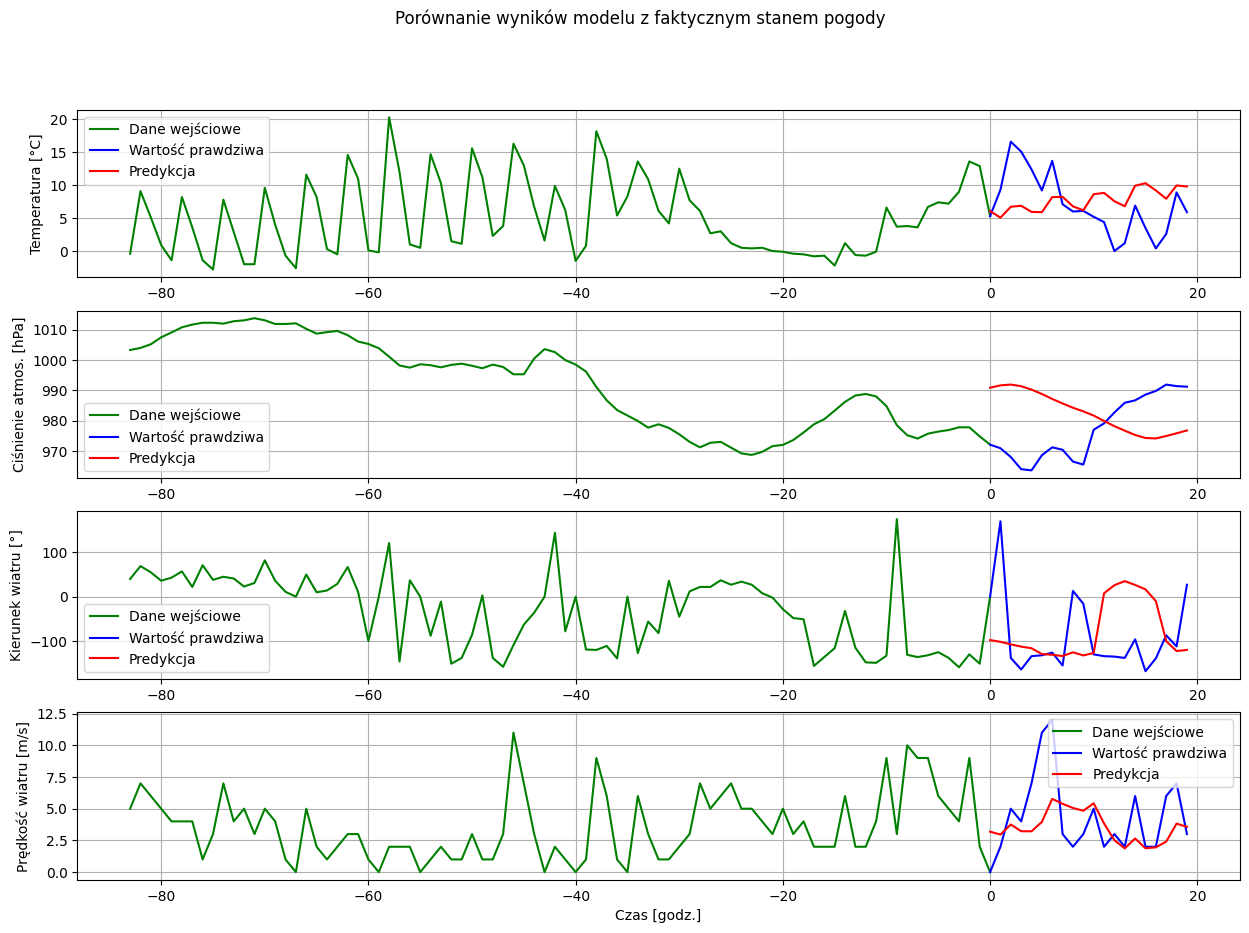

In [22]:
plot_one_prediction(300, real_X_test, real_y_test, real_y_pred)

In [ ]:
MSE(real_y_test, real_y_pred)[0]

In [ ]:
MSE(real_y_test, real_y_pred)[1]

In [ ]:
X_test

In [ ]:
inv_X_test